# IPCV Assignment 2

Authors:

- Mauro Dore             - mauro.dore@studio.unibo.it            - 0001105149
- Gian Mario Marongiu    - gianmario.marongiu@studio.unibo.it    - 0001092260
- Riccardo Murgia        - riccardo.murgia2@studio.unibo.it      - 0001083930

## Imports and Dataset Download

In [1]:
# dataset download
#!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [2]:
import os
from pathlib import Path
import numpy as np
import json

from PIL import Image
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"-{device}- is being used")

-cuda- is being used


## Auxiliary Functions

In [3]:
class GroceryStoreDataset(Dataset):
    
    def __init__(self, split: str, transform=None) -> None:
        """
        Initialize dataset with specified split and transformations.
        """
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        """
        Get a single sample from the dataset.
        """
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        """
        Read dataset file containing image paths and labels.
        """
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        """Return total number of unique classes in the dataset."""
        return max(self.labels) + 1
    
    def get_dataloader(self, batch_size, shuffle):
        """Create a DataLoader for this dataset."""
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle)

def plot_training_multiple_results(results_dict, title=None):
    """
    Plot training and validation metrics from multiple training runs.
    """
    # Extract metrics from results dictionary
    train_losses_list = results_dict["train_losses"]
    val_losses_list = results_dict["val_losses"]
    train_accuracies_list = results_dict["train_accuracies"]
    val_accuracies_list = results_dict["val_accuracies"]
    best_epochs = results_dict["best_epoch"]
    
    # Calculate overall statistics
    max_epochs = max([len(run) for run in train_losses_list])
    avg_best_results = np.mean([val_accuracies_list[i][best_epochs[i]] for i in range(len(best_epochs))])
    
    # Initialize arrays for statistics
    avg_train_losses, avg_val_losses = [], []
    min_train_losses, min_val_losses = [], []
    max_train_losses, max_val_losses = [], []
    
    avg_train_accuracies, avg_val_accuracies = [], []
    min_train_accuracies, min_val_accuracies = [], []
    max_train_accuracies, max_val_accuracies = [], []
    
    # Calculate statistics for each epoch
    for epoch in range(max_epochs):
        # Get metrics for current epoch across all runs
        train_losses_epoch = [run[epoch] for run in train_losses_list if len(run) > epoch]
        val_losses_epoch = [run[epoch] for run in val_losses_list if len(run) > epoch]
        train_accuracies_epoch = [run[epoch] for run in train_accuracies_list if len(run) > epoch]
        val_accuracies_epoch = [run[epoch] for run in val_accuracies_list if len(run) > epoch]
        
        # Calculate mean, min, max for losses
        avg_train_losses.append(np.mean(train_losses_epoch))
        avg_val_losses.append(np.mean(val_losses_epoch))
        min_train_losses.append(np.min(train_losses_epoch))
        min_val_losses.append(np.min(val_losses_epoch))
        max_train_losses.append(np.max(train_losses_epoch))
        max_val_losses.append(np.max(val_losses_epoch))

        # Calculate mean, min, max for accuracies
        avg_train_accuracies.append(np.mean(train_accuracies_epoch))
        avg_val_accuracies.append(np.mean(val_accuracies_epoch))
        min_train_accuracies.append(np.min(train_accuracies_epoch))
        min_val_accuracies.append(np.min(val_accuracies_epoch))
        max_train_accuracies.append(np.max(train_accuracies_epoch))
        max_val_accuracies.append(np.max(val_accuracies_epoch))

    epochs = range(1, len(avg_train_losses) + 1)

    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss curves
    axs[0].plot(epochs, avg_train_losses, label='Avg Train Loss', color='blue')
    axs[0].plot(epochs, avg_val_losses, label='Avg Val Loss', color='orange')
    axs[0].fill_between(epochs, min_train_losses, max_train_losses, color='blue', alpha=0.2)
    axs[0].fill_between(epochs, min_val_losses, max_val_losses, color='orange', alpha=0.2)
    axs[0].set_title('Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', alpha=0.7)

    # Plot accuracy curves
    axs[1].plot(epochs, avg_train_accuracies, label='Avg Train Accuracy', color='blue')
    axs[1].plot(epochs, avg_val_accuracies, label='Avg Val Accuracy', color='orange')
    axs[1].fill_between(epochs, min_train_accuracies, max_train_accuracies, color='blue', alpha=0.2)
    axs[1].fill_between(epochs, min_val_accuracies, max_val_accuracies, color='orange', alpha=0.2)
    axs[1].set_title('Accuracy vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', alpha=0.7)

    # Add overall title and summary statistics
    if title:
        fig.suptitle(title, fontsize=16)
    fig.text(0.5, -0.05, f"Average Best Validation Accuracy over {len(best_epochs)} trainings: {avg_best_results:.5f}",
             ha='center', fontsize=16, color='black')

    plt.tight_layout(rect=(0, 0.05, 1, 0.95))
    plt.show()

## Dataset Statistics and Configuration

The following cell calculates important dataset statistics further used for training and preprocessing, specifically the process includes:
- Combining the train, validation, and test sets into a single dataset.
- Tracking Image Dimensions: A record of each unique image dimension (width and height) is maintained to help identify any size variations in the dataset.
- Calculating Mean and Standard Deviation: For each color channel, pixel means and standard deviations are computed across all images.

In [4]:
# Global dataset with no transformations
train_dataset_no_preprocessing = GroceryStoreDataset("train", transform=transforms.ToTensor())
val_dataset_no_preprocessing = GroceryStoreDataset("val", transform=transforms.ToTensor())
test_dataset_no_preprocessing = GroceryStoreDataset("test", transform=transforms.ToTensor())
global_dataset = torch.utils.data.ConcatDataset([train_dataset_no_preprocessing, val_dataset_no_preprocessing, test_dataset_no_preprocessing])

# Initialize variables to accumulate mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
num_pixels = 0

# Dictionary to keep track of image shapes
shapes = {}

# Loop through the global dataset
for img, _ in tqdm(global_dataset, desc="Collecting image dimensions and computing statistics"):
    channels, height, width = img.shape
    
    # Update shape occurrences
    if shapes.get((width, height)) is None:
        shapes[(width, height)] = 1
    else:
        shapes[(width, height)] += 1

    # Compute the number of pixels per image
    num_pixels += height * width
    
    # Sum the mean values of each channel (mean for each pixel)
    mean += img.view(channels, -1).mean(dim=1)
    
    # Sum the squared differences for std calculation
    std += img.view(channels, -1).std(dim=1)

# Divide the sum of means and std by the total number of images to get the final mean and std
mean /= len(global_dataset)
std /= len(global_dataset)

print("Mean and standard deviation of image channels:")
print(f"Mean: {mean}")
print(f"Std: {std}")

print("\nShapes of images in the dataset")
for shape, occurrences in shapes.items():
    print(f"Shape: {shape} \t Occurrences: {occurrences}")
    

Mean and standard deviation of image channels:
Mean: tensor([0.5278, 0.3966, 0.2577])
Std: tensor([0.2337, 0.2101, 0.1793])

Shapes of images in the dataset
Shape: (348, 348) 	 Occurrences: 4958
Shape: (348, 464) 	 Occurrences: 426
Shape: (464, 348) 	 Occurrences: 37


A configuration dictionary (config) stores the hyperparameters:

- Image cropping size is set to 300, according to the shapes of the images in the dataset. We choose 300 to retain most of the image pixels while allowing enough "excluded" pixels to introduce diversity when randomly selecting a 300×300 area from the original images.
- Batch size is set to the highest value that the current hardware allows.
- Learning rate was determined after a few manual tests, which are not shown in the notebook.
- The number of epochs is set to a high value (100), but this is almost irrelevant as we use early stopping with patience = 12.
- We specify the number of training runs, i.e., how many times we train the model for each combination of architecture and hyperparameters. This ensures robustness in the results, preventing misleading conclusions due to occasional high accuracy in a single training run.
- Finally, we store the mean and standard deviation computed above; these values will be used to normalize the input images before feeding them into the model.


In [5]:
# hyperparameters
config = {
    "crop_size": 300,
    
    "batch_size": 64,
    "learning_rate": 5e-4,
    "num_epochs": 100,
    "patience": 12,
    "num_trainings": 5,
    
    "global_mean": mean,
    "global_std": std
}


## Data Augmentation and Preprocessing

This section defines separate preprocessing pipelines for the training and validation datasets to optimize model performance:

Training Set - Data augmentation is applied to improve the model's generalization ability:
- RandomResizedCrop: Randomly crops images to a target size (crop_size, derived from global dataset analysis), introducing variability while standardizing input dimensions.
- RandomHorizontalFlip: Randomly flips images horizontally to increase diversity.
- ToTensor: Converts images to tensors, making them compatible with PyTorch models.

Validation Set - No augmentation is applied to validation data to ensure consistency and accurate evaluation:
- CenterCrop: Crops images to the fixed target size (crop_size) to prevent dimension mismatches.
- ToTensor: Converts images to tensors, making them compatible with PyTorch models.

Additionally, both training and validation set are subject to a normalization step. This step standardizes pixel values using the computed global mean and standard deviation, stabilizing training by ensuring input values have a mean of 0 and standard deviation of 1.

In [6]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(config["crop_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(config["global_mean"], config["global_std"])
])

transform_val = transforms.Compose([
    transforms.CenterCrop(config["crop_size"]),
    transforms.ToTensor(),
    transforms.Normalize(config["global_mean"], config["global_std"])
])


training_set = GroceryStoreDataset("train", transform=transform_train)
validation_set = GroceryStoreDataset("val", transform=transform_val)


In [7]:
def train_and_validate(model, 
                       train_set=training_set, 
                       val_set=validation_set, 
                       config=config, 
                       device=device, 
                       model_name=None, 
                       verbose=True):
    model.to(device)
    train_loader = train_set.get_dataloader(config["batch_size"], shuffle=True)
    val_loader = val_set.get_dataloader(config["batch_size"], shuffle=False)
    optimizer=optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    best_val_acc = -np.inf
    best_val_idx = 0
    epochs_without_improvement = 0
    
    for epoch in range(config["num_epochs"]):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train_preds, total_train_preds = 0, 0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad() 
            
            outputs = model(inputs)             # Forward pass
            loss = criterion(outputs, labels)   # Calculate loss
            loss.backward()                     # Backward pass
            optimizer.step()                    # Optimize
            
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()
            total_train_preds += labels.size(0)
        
        # Calculate and store average training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train_preds / total_train_preds
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val_preds, total_val_preds = 0, 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val_preds += (predicted == labels).sum().item()
                total_val_preds += labels.size(0)
        
        # Calculate and store average validation loss and accuracy for the epoch
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val_preds / total_val_preds
        val_accuracies.append(val_accuracy)
        
        # Calculate the time taken for this epoch
        epoch_time = time.time() - start_time

        # Print training, validation results, and epoch time
        if verbose:
            print(f"Epoch [{epoch+1}/{config['num_epochs']}] "
                  f"Time: {epoch_time:.2f} seconds, "
                  f"Train Loss: {train_losses[-1]:.6f}, "
                  f"Train Accuracy: {train_accuracies[-1]:.6f}, "
                  f"Val Loss: {val_losses[-1]:.6f}, "
                  f"Val Accuracy: {val_accuracies[-1]:.6f}")
        
        # Early stopping check
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            best_val_idx = len(val_accuracies) - 1
            epochs_without_improvement = 0  # Reset counter if we have improvement
            
            # Save current best weights
            if model_name:
                if not os.path.exists("weights"):
                    os.makedirs("weights")
                torch.save(model.state_dict(), os.path.join("weights", f"{model_name}.pth"))
        else:
            epochs_without_improvement += 1  # Increment counter if no improvement
            
        if epochs_without_improvement >= config["patience"]:
            if verbose:
                print(f"Early stopping triggered. Best validation accuracy of {best_val_acc:.6f} found at epoch {best_val_idx + 1}.")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_idx


## Part 1: Custom Model

The custom model `CNN_v1` is designed to achieve a target accuracy greater than 60%. It includes the following components:

- **Five Convolutional Layers:** Each convolutional layer progressively increases the number of output channels, starting from 16 up to 256 channels. This design allows the model to capture basic features, like edges and textures, in the initial layers, and more complex, abstract features in the deeper layers.

- **Batch Normalization:** Each convolutional layer is followed by batch normalization, which normalizes the activations, stabilizing and accelerating the training process while also helping to prevent overfitting.

- **Activation Function:** The ReLU activation function is applied after each convolutional layer. ReLU introduces non-linearity, enabling the model to learn more complex patterns without the vanishing gradient problem.

- **Max Pooling Layers:** Max pooling is used to reduce the spatial dimensions of the feature maps, which helps to downsample the feature maps, reduce computational cost, and prevent overfitting.

- **Adaptive Average Pooling:** An adaptive average pooling layer is used before the fully connected layer, guaranteeing a fixed output size of (1,1) for each feature map channel, regardless of the input dimensions. While this layer adds flexibility for varying input sizes, the current setup preprocesses all images to a fixed size, so its primary role here is to reduce the spatial dimensions to a single value per channel.

- **Classification Head:** The model ends with a fully connected layer (`fc1`) that outputs predictions for the specified number of classes. This layer combines the learned features to produce the final classification output.

Training is conducted multiple times to ensure robustness, using the Adam optimizer and a batch size of 64—the maximum batch size supported by the available hardware.


In [15]:
class CNN_v1(nn.Module):
    def __init__(self, n_classes=43):
        super(CNN_v1, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding="same") 
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same")
        self.bn5 = nn.BatchNorm2d(256)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        
        # Adjust the input size of the fully connected layer based on the pooling output size
        self.fc1 = nn.Linear(256 * 1 * 1, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        
        x = self.avg_pooling(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        
        return x
    
cnn_v1 = CNN_v1()
summary(cnn_v1.to(device), input_size=(3, config["crop_size"], config["crop_size"]), batch_size=config["batch_size"])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 300, 300]           1,216
       BatchNorm2d-2         [64, 16, 300, 300]              32
         MaxPool2d-3         [64, 16, 150, 150]               0
            Conv2d-4         [64, 32, 150, 150]           4,640
       BatchNorm2d-5         [64, 32, 150, 150]              64
         MaxPool2d-6           [64, 32, 75, 75]               0
            Conv2d-7           [64, 64, 75, 75]          18,496
       BatchNorm2d-8           [64, 64, 75, 75]             128
         MaxPool2d-9           [64, 64, 37, 37]               0
           Conv2d-10          [64, 128, 37, 37]          73,856
      BatchNorm2d-11          [64, 128, 37, 37]             256
        MaxPool2d-12          [64, 128, 18, 18]               0
           Conv2d-13          [64, 256, 18, 18]         295,168
      BatchNorm2d-14          [64, 256,

In [19]:
results_cnn_v1 = {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": [], "best_epoch": []}

for training in tqdm(range(config["num_trainings"]), desc="Training"):
    train_losses, val_losses, train_acc, val_acc, best_epoch = train_and_validate(cnn_v1, model_name="cnn_v1", verbose=False)
    
    results_cnn_v1["train_losses"].append(train_losses)
    results_cnn_v1["val_losses"].append(val_losses)
    results_cnn_v1["train_accuracies"].append(train_acc)
    results_cnn_v1["val_accuracies"].append(val_acc)
    results_cnn_v1["best_epoch"].append(best_epoch)
    
    cnn_v1 = CNN_v1()
    

with open(os.path.join("results", "cnn_v1.json"), 'w') as json_file:
    json.dump(results_cnn_v1, json_file, indent=4)
    

Training: 100%|██████████| 5/5 [43:57<00:00, 527.42s/it]


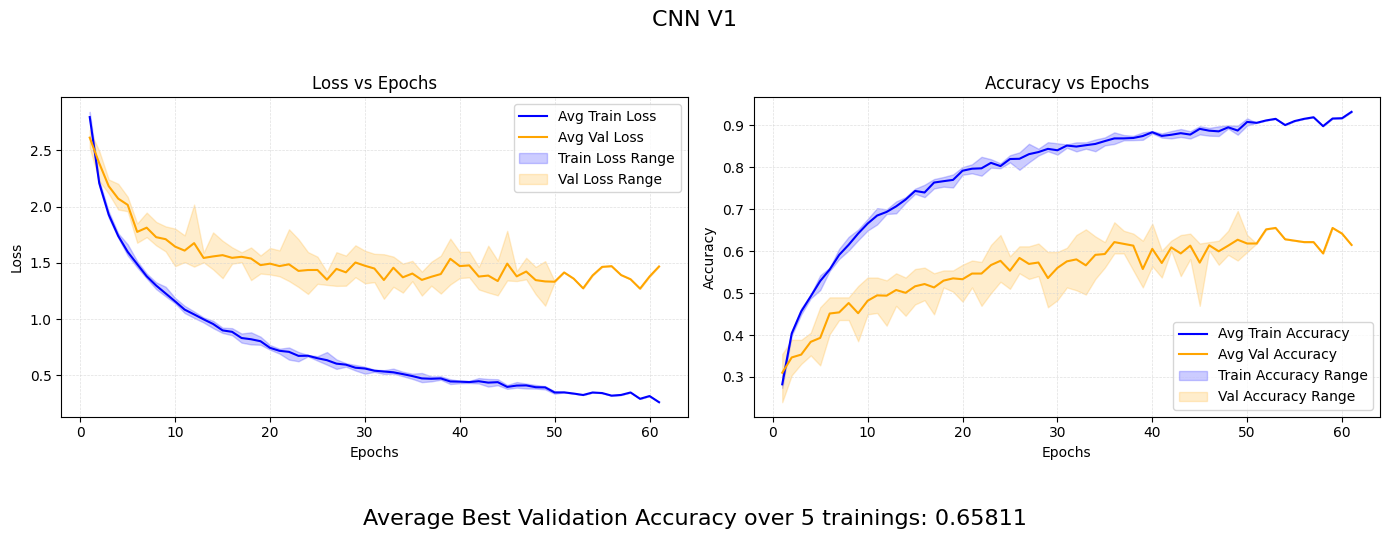

In [20]:
plot_training_multiple_results(results_cnn_v1, title="CNN V1")


## Ablation Study on CNN_v1

---

### Removing Batch Normalization

This version of the model, `CNN_no_bn`, excludes batch normalization layers to evaluate the impact of batch normalization on performance. By removing batch normalization, we can observe its effect on training stability and model accuracy. In our tests, while the training time remained similar, the average performance across multiple executions was approximately 10% lower than the original model. 

This suggests that batch normalization contributes significantly to improving model robustness and overall accuracy.


In [14]:
class CNN_no_bn(nn.Module):
    def __init__(self, n_classes=43):
        super(CNN_no_bn, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding="same") 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same")
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        
        # Adjust the input size of the fully connected layer based on the pooling output size
        self.fc1 = nn.Linear(256 * 1 * 1, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        
        x = self.avg_pooling(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        
        return x
    
cnn_no_bn = CNN_no_bn()
summary(cnn_no_bn.to(device), input_size=(3, config["crop_size"], config["crop_size"]), batch_size=config["batch_size"])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 300, 300]           1,216
         MaxPool2d-2         [64, 16, 150, 150]               0
            Conv2d-3         [64, 32, 150, 150]           4,640
         MaxPool2d-4           [64, 32, 75, 75]               0
            Conv2d-5           [64, 64, 75, 75]          18,496
         MaxPool2d-6           [64, 64, 37, 37]               0
            Conv2d-7          [64, 128, 37, 37]          73,856
         MaxPool2d-8          [64, 128, 18, 18]               0
            Conv2d-9          [64, 256, 18, 18]         295,168
AdaptiveAvgPool2d-10            [64, 256, 1, 1]               0
           Linear-11                   [64, 43]          11,051
Total params: 404,427
Trainable params: 404,427
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 65.92
Forward

In [15]:
results_CNN_no_bn = {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": [], "best_epoch": []}
    
for training in tqdm(range(config["num_trainings"]), desc="Training"):
    train_losses, val_losses, train_acc, val_acc, best_epoch = train_and_validate(cnn_no_bn, model_name="CNN_no_bn", verbose=False)
    
    results_CNN_no_bn["train_losses"].append(train_losses)
    results_CNN_no_bn["val_losses"].append(val_losses)
    results_CNN_no_bn["train_accuracies"].append(train_acc)
    results_CNN_no_bn["val_accuracies"].append(val_acc)
    results_CNN_no_bn["best_epoch"].append(best_epoch)
    
    cnn_no_bn = CNN_no_bn()

with open(os.path.join("results", "CNN_no_bn.json"), 'w') as json_file:
    json.dump(results_CNN_no_bn, json_file, indent=4)


Training: 100%|██████████| 5/5 [46:24<00:00, 556.94s/it]


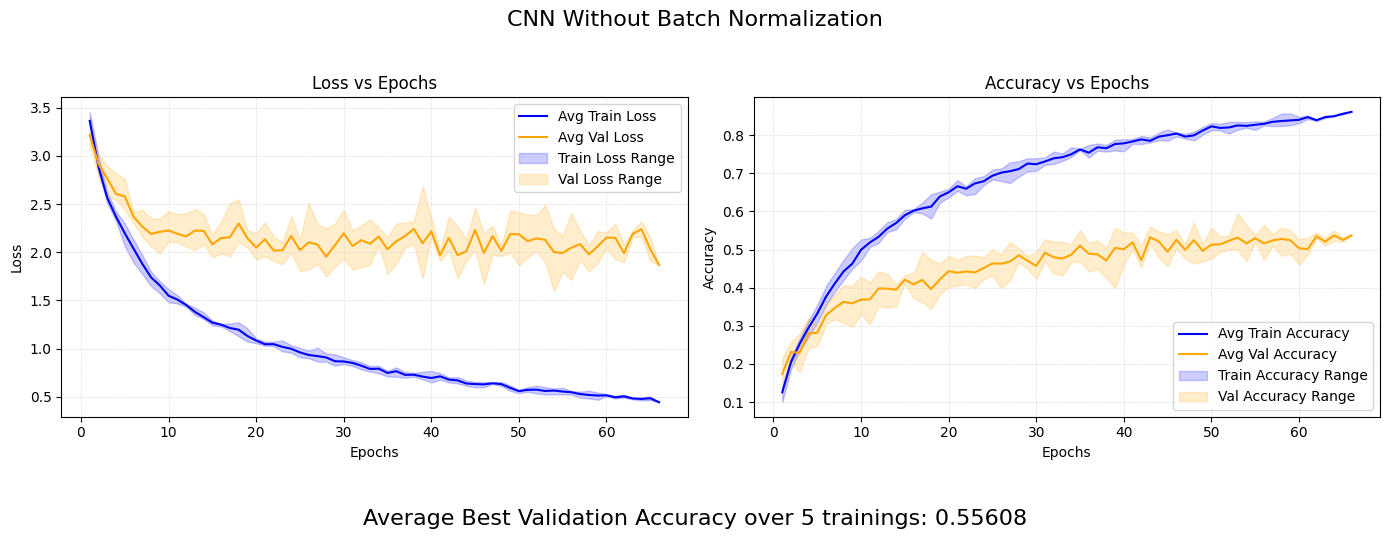

In [16]:
plot_training_multiple_results(results_CNN_no_bn, title="CNN Without Batch Normalization")


### Removing Max Pooling

In this model, `CNN_no_mp`, max pooling layers are removed to analyze the impact of downsampling on model efficiency and accuracy. Without max pooling, each layer retains the full spatial dimensions of the feature maps, resulting in significantly increased computational requirements—training time was approximately 8 times longer compared to the original model.

In terms of performance, accuracy was slightly higher than the model without batch normalization but still fell short by about 7% compared to the original model with both batch normalization and max pooling. This indicates that max pooling not only reduces computational cost but also plays a role in preserving essential features for better generalization.


In [9]:
class CNN_no_mp(nn.Module):
    def __init__(self, n_classes=43):
        super(CNN_no_mp, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding="same") 
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same")
        self.bn5 = nn.BatchNorm2d(256)
        
        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Adjust the input size of the fully connected layer based on the pooling output size
        self.fc1 = nn.Linear(256 * 1 * 1, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        
        x = self.avg_pooling(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        
        return x


cnn_no_mp = CNN_no_mp()
summary(cnn_no_mp.to(device), input_size=(3, config["crop_size"], config["crop_size"]), batch_size=config["batch_size"])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 300, 300]           1,216
       BatchNorm2d-2         [64, 16, 300, 300]              32
            Conv2d-3         [64, 32, 300, 300]           4,640
       BatchNorm2d-4         [64, 32, 300, 300]              64
         MaxPool2d-5         [64, 32, 150, 150]               0
            Conv2d-6         [64, 64, 150, 150]          18,496
       BatchNorm2d-7         [64, 64, 150, 150]             128
            Conv2d-8        [64, 128, 150, 150]          73,856
       BatchNorm2d-9        [64, 128, 150, 150]             256
        MaxPool2d-10          [64, 128, 75, 75]               0
           Conv2d-11          [64, 256, 75, 75]         295,168
      BatchNorm2d-12          [64, 256, 75, 75]             512
AdaptiveAvgPool2d-13            [64, 256, 1, 1]               0
           Linear-14                   

In [10]:
results_CNN_no_mp = {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": [], "best_epoch": []}
    
for training in tqdm(range(config["num_trainings"]), desc="Training"):
    train_losses, val_losses, train_acc, val_acc, best_epoch = train_and_validate(cnn_no_mp, model_name="CNN_no_mp", verbose=False)
    
    results_CNN_no_mp["train_losses"].append(train_losses)
    results_CNN_no_mp["val_losses"].append(val_losses)
    results_CNN_no_mp["train_accuracies"].append(train_acc)
    results_CNN_no_mp["val_accuracies"].append(val_acc)
    results_CNN_no_mp["best_epoch"].append(best_epoch)
    
    cnn_no_mp = CNN_no_mp()

with open(os.path.join("results", "CNN_no_mp.json"), 'w') as json_file:
    json.dump(results_CNN_no_mp, json_file, indent=4)


Training: 100%|██████████| 5/5 [5:29:50<00:00, 3958.20s/it]  


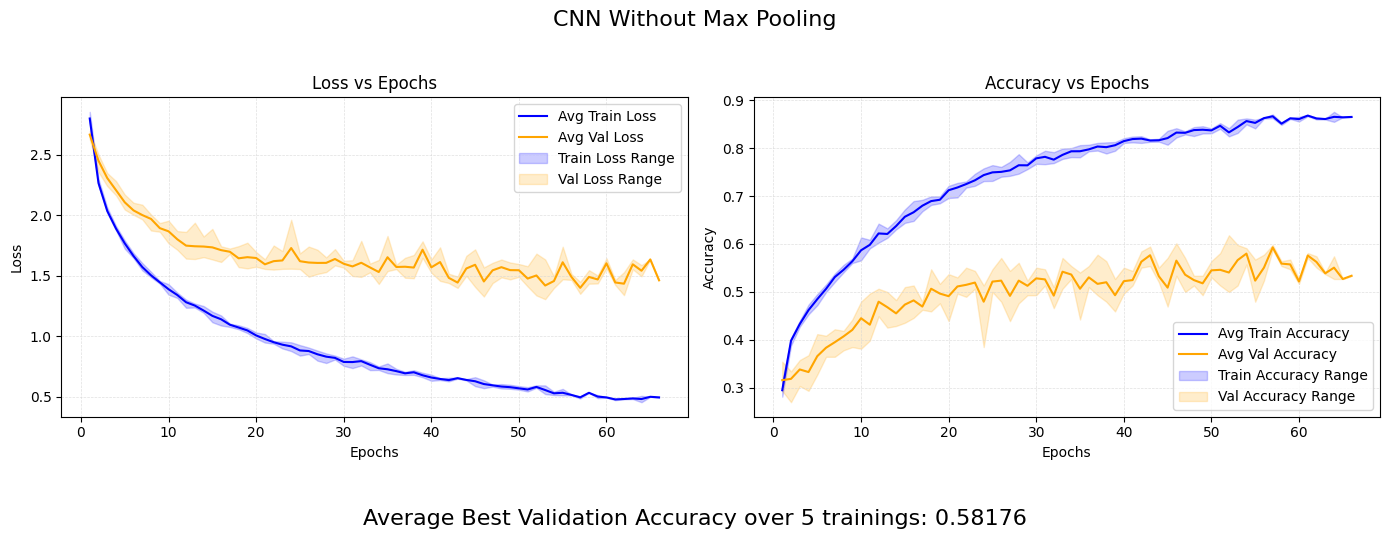

In [11]:
plot_training_multiple_results(results_CNN_no_mp, title="CNN Without Max Pooling")


## Part 2:  Res-Net Fine Tuning

---

### Res-Net with Parameters Used Above

In this setup, we use a ResNet18 model pre-trained on the ImageNet dataset.

- **Freezing Layers:** the `set_requires_grad` function is used to freeze the feature extractor layers of the model.

- **Custom Classification Head:** the fully connected layer (`fc`) is replaced to match the number of target classes (43). This new layer will learn from scratch during training, allowing the model to specialize in the current dataset's classification task.

This approach enables efficient transfer learning, where only the final layers are fine-tuned for our specific classification problem, while the lower layers provide robust feature extraction based on pre-trained weights.



In [16]:
def set_requires_grad(layer: torch.nn.Module, train: bool):
    for p in layer.parameters():
        p.requires_grad = train
        
def get_resnet18(num_classes: int, weights: ResNet18_Weights, unfreeze_last_layer: bool = False):
    model = resnet18(weights=weights)
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    set_requires_grad(model.conv1, False)
    set_requires_grad(model.bn1, False)
    set_requires_grad(model.layer1, False)
    set_requires_grad(model.layer2, False)
    set_requires_grad(model.layer3, False)
    set_requires_grad(model.layer4, unfreeze_last_layer)
    
    return model

resnet18_v1 = get_resnet18(num_classes=43, weights=ResNet18_Weights.IMAGENET1K_V1)
summary(resnet18_v1.to(device), input_size=(3, config["crop_size"], config["crop_size"]), batch_size=config["batch_size"])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 150, 150]           9,408
       BatchNorm2d-2         [64, 64, 150, 150]             128
              ReLU-3         [64, 64, 150, 150]               0
         MaxPool2d-4           [64, 64, 75, 75]               0
            Conv2d-5           [64, 64, 75, 75]          36,864
       BatchNorm2d-6           [64, 64, 75, 75]             128
              ReLU-7           [64, 64, 75, 75]               0
            Conv2d-8           [64, 64, 75, 75]          36,864
       BatchNorm2d-9           [64, 64, 75, 75]             128
             ReLU-10           [64, 64, 75, 75]               0
       BasicBlock-11           [64, 64, 75, 75]               0
           Conv2d-12           [64, 64, 75, 75]          36,864
      BatchNorm2d-13           [64, 64, 75, 75]             128
             ReLU-14           [64, 64,

In [11]:
results_resnet_v1 = {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": [], "best_epoch": []}
    
for training in tqdm(range(config["num_trainings"]), desc="Training"):
    train_losses, val_losses, train_acc, val_acc, best_epoch = train_and_validate(resnet18_v1, model_name="resnet_v1", verbose=False)
    
    results_resnet_v1["train_losses"].append(train_losses)
    results_resnet_v1["val_losses"].append(val_losses)
    results_resnet_v1["train_accuracies"].append(train_acc)
    results_resnet_v1["val_accuracies"].append(val_acc)
    results_resnet_v1["best_epoch"].append(best_epoch)
    
    resnet18_v1 = get_resnet18(num_classes=43, weights=ResNet18_Weights.IMAGENET1K_V1)

with open(os.path.join("results", "resnet_v1.json"), 'w') as json_file:
    json.dump(results_resnet_v1, json_file, indent=4)


Training: 100%|██████████| 5/5 [44:53<00:00, 538.77s/it]


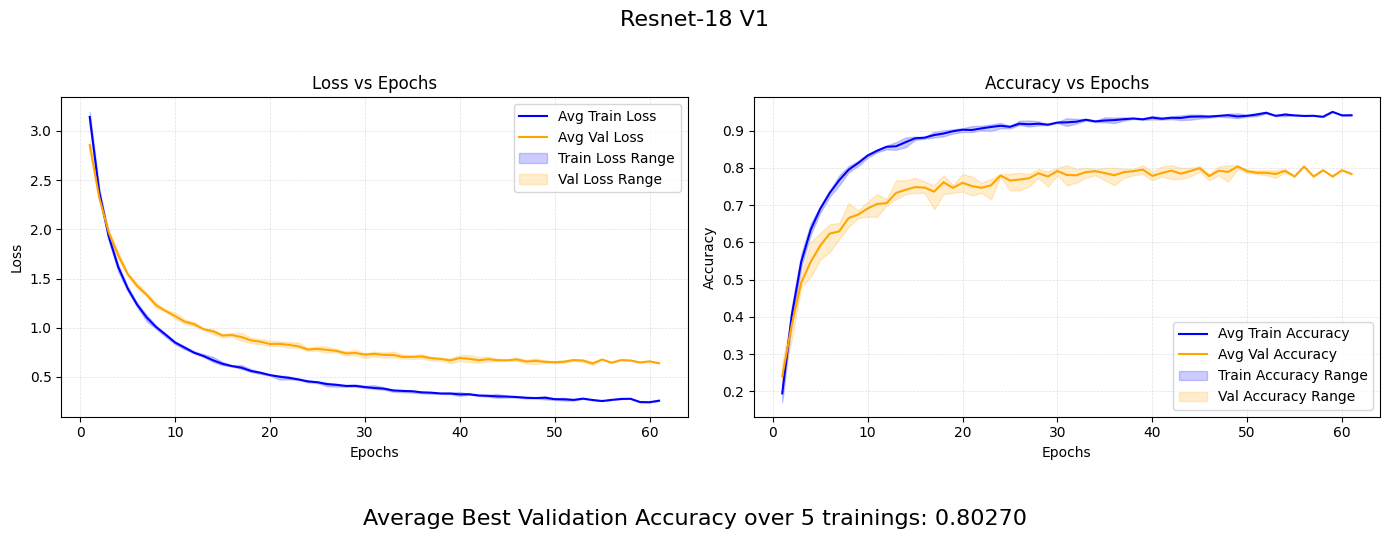

In [12]:
plot_training_multiple_results(results_resnet_v1, title="Resnet-18 V1")

## Res-Net with tweaked Parameters (1)

This code performs a grid search to identify the optimal learning rate and batch size for training the ResNet18 model, aiming to improve performance.

- **Hyperparameter Selection:** We test a range of values for the learning rate (`learning_rate_to_test`) and batch size (`batch_size_to_test`). For each combination, the model is trained multiple times (specified by `num_trainings` in the configuration) to ensure robustness and account for any variance in training performance.

- **Storing Results:** For each learning rate and batch size combination, training and validation losses and accuracies, along with the best-performing epoch, are recorded and stored in `results_resnet`. This allows for easy comparison across configurations.

- **Saving and Plotting:** After each configuration is evaluated, results are saved to a JSON file for future reference, and a training plot is generated to visualize performance trends.

Using this grid search, we improved the model's performance from 0.8027 to 0.8189, demonstrating the impact of hyperparameter tuning on model accuracy.


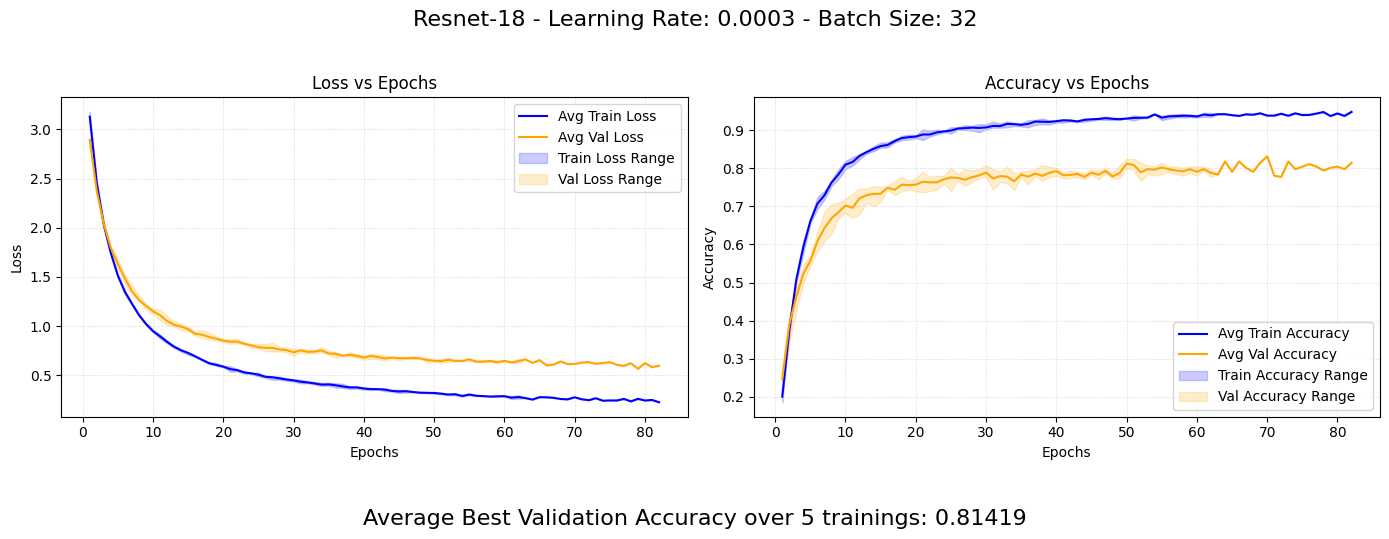

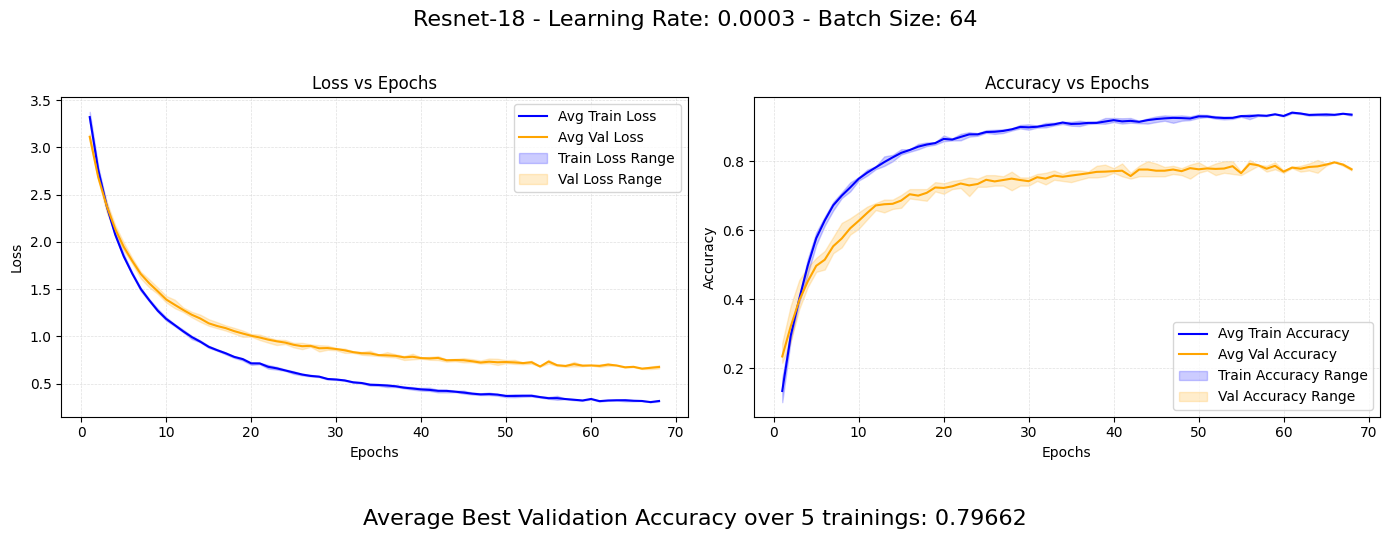

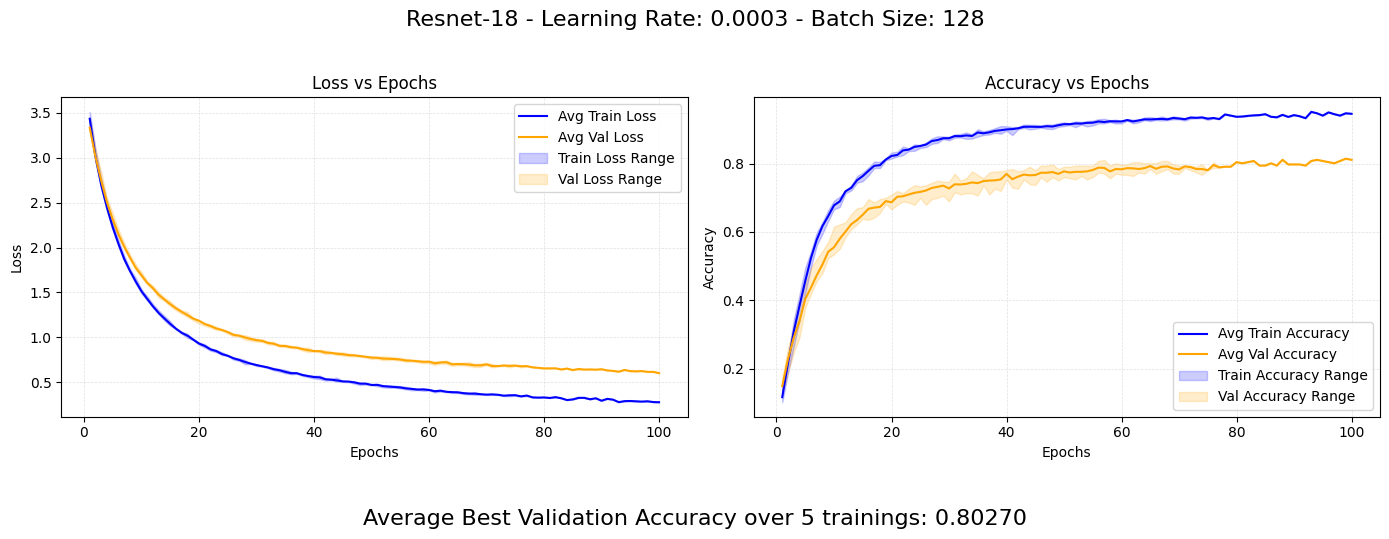

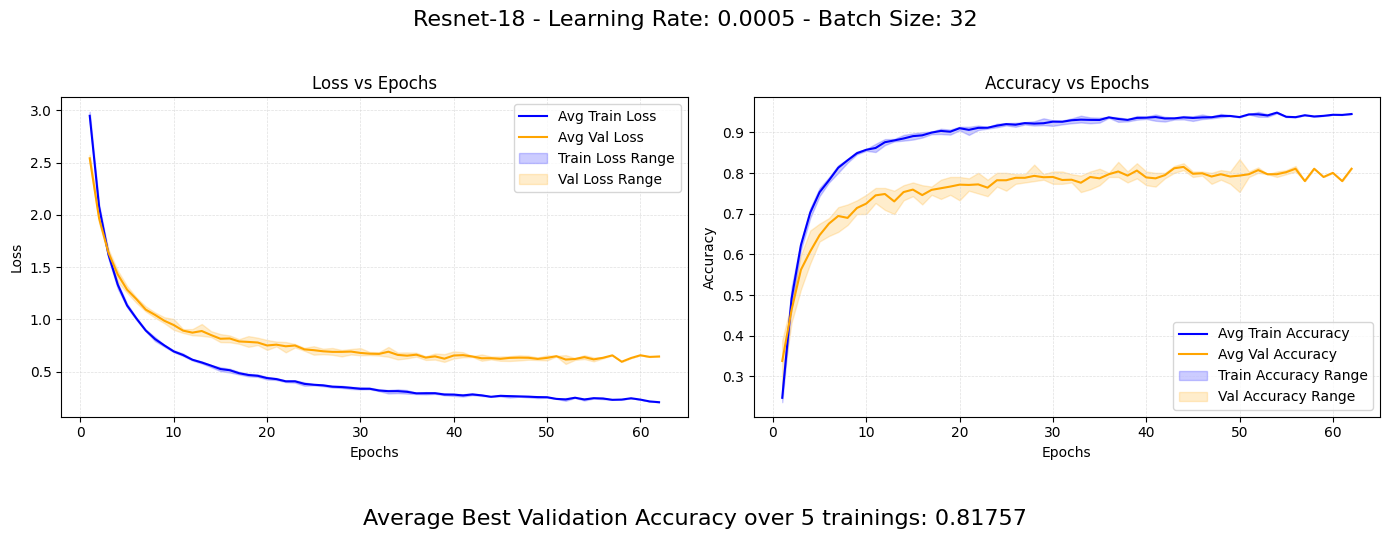

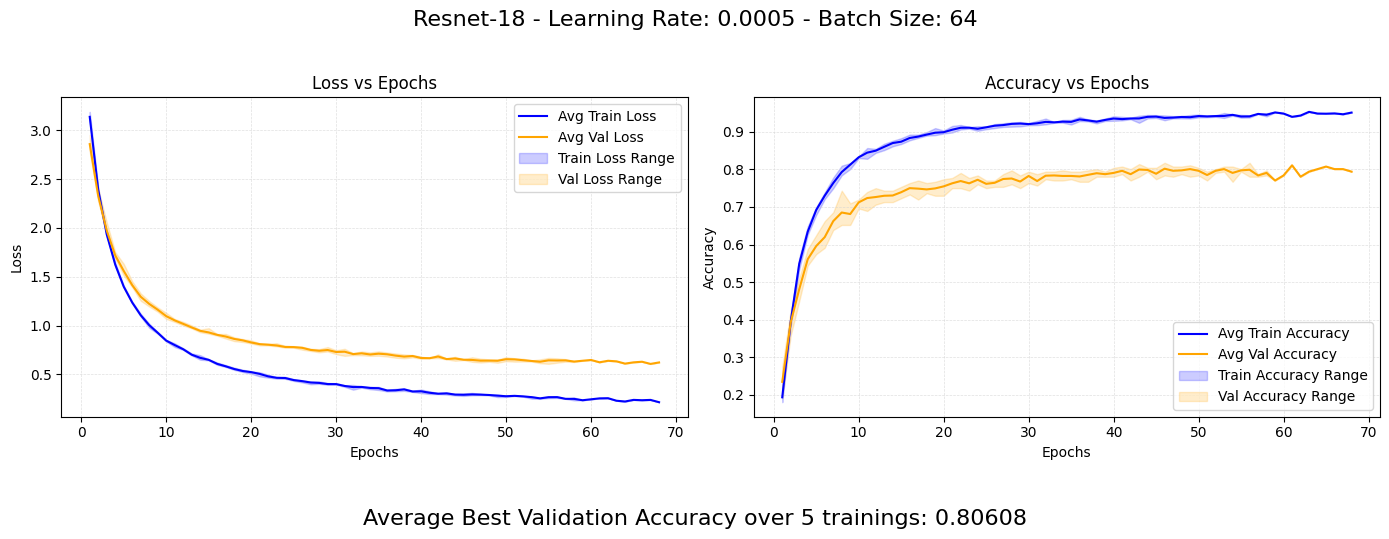

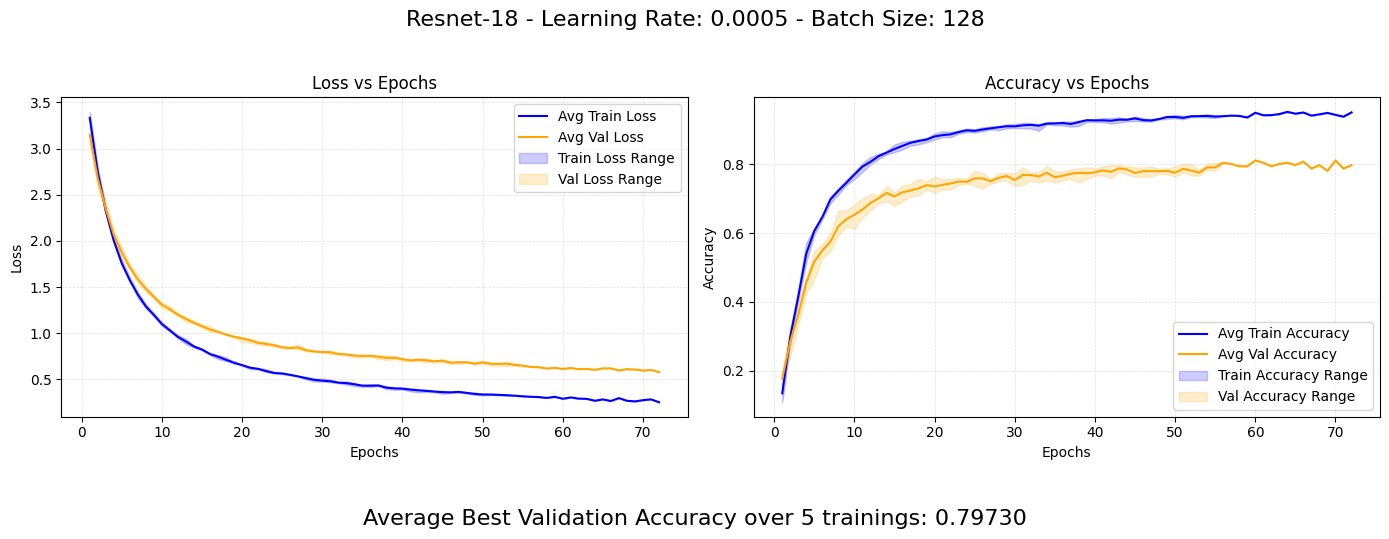

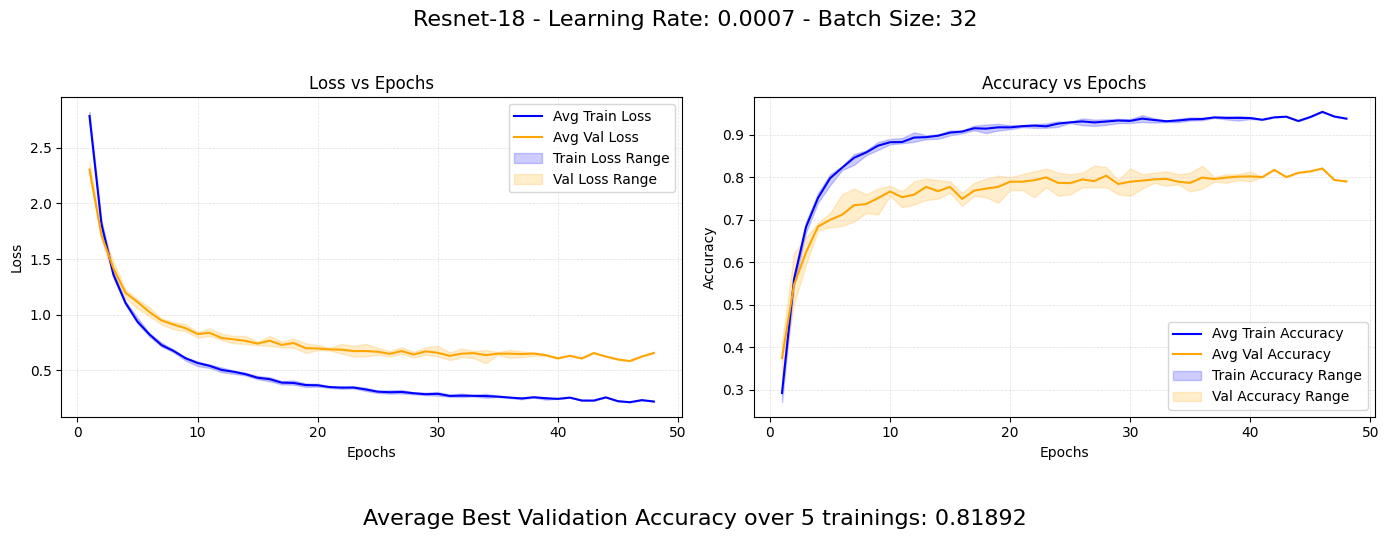

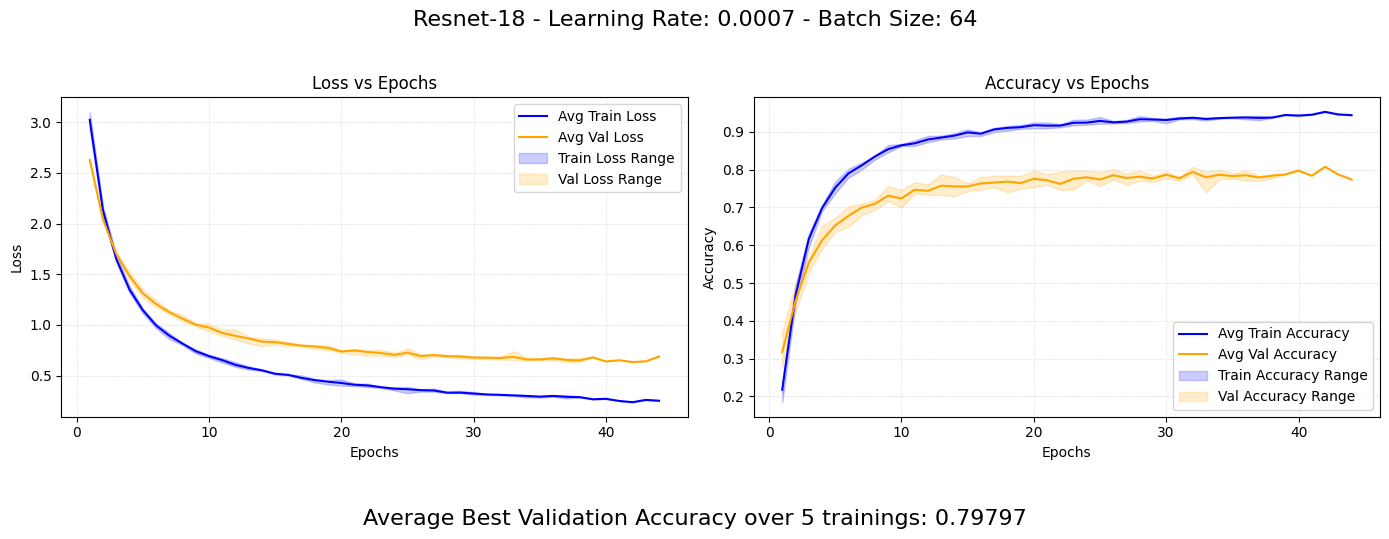

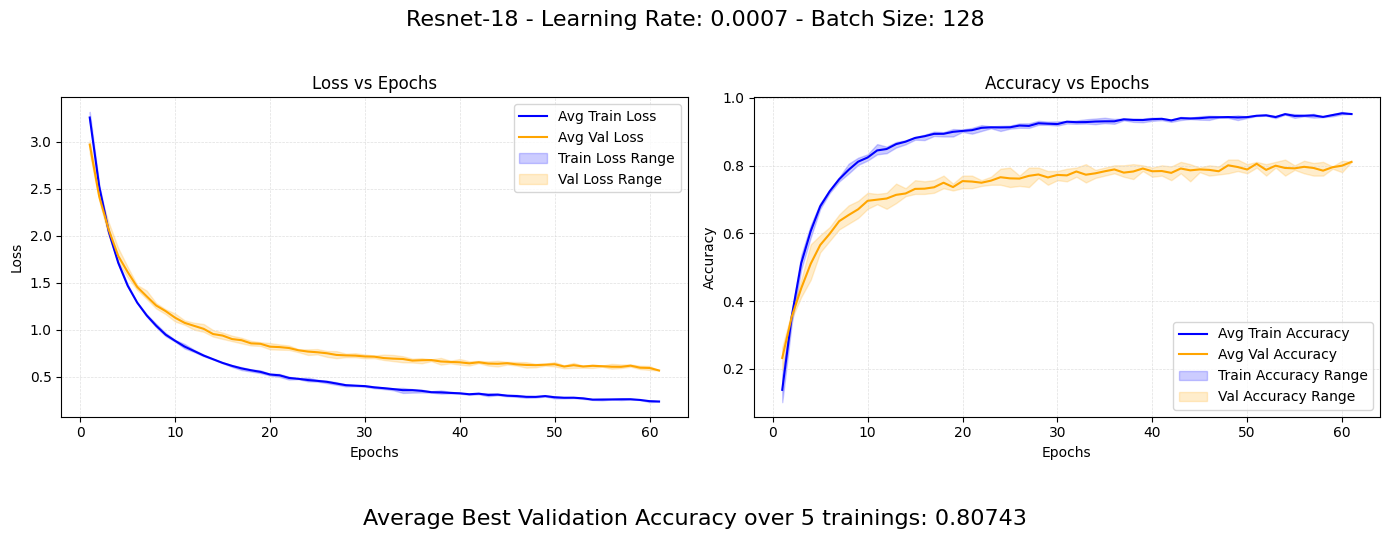

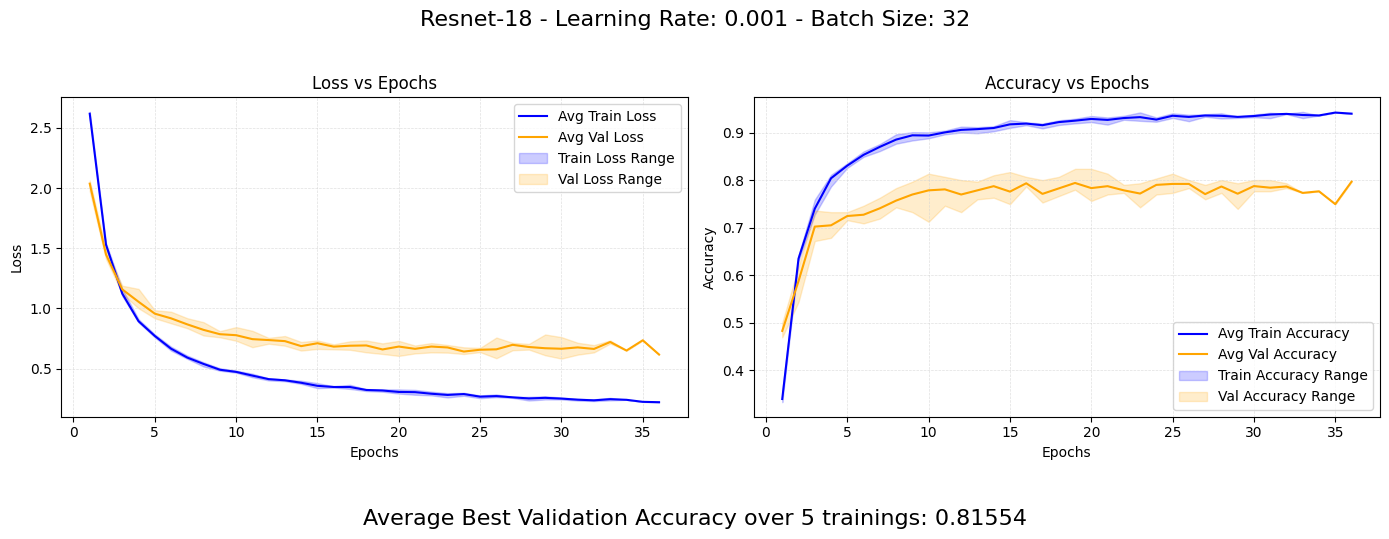

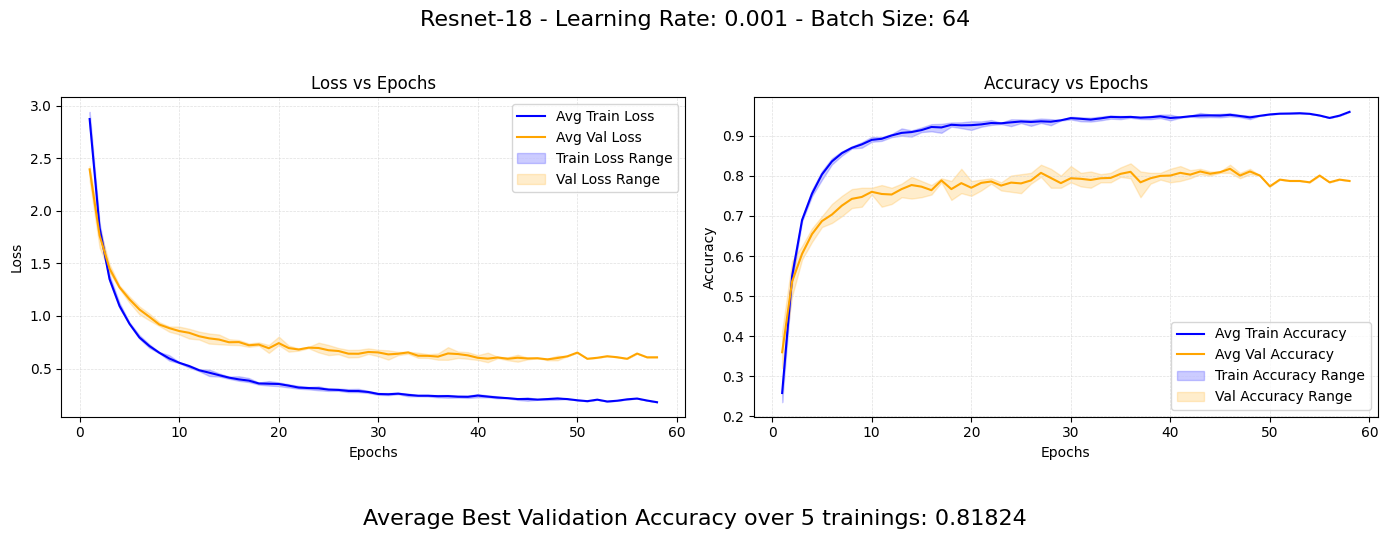

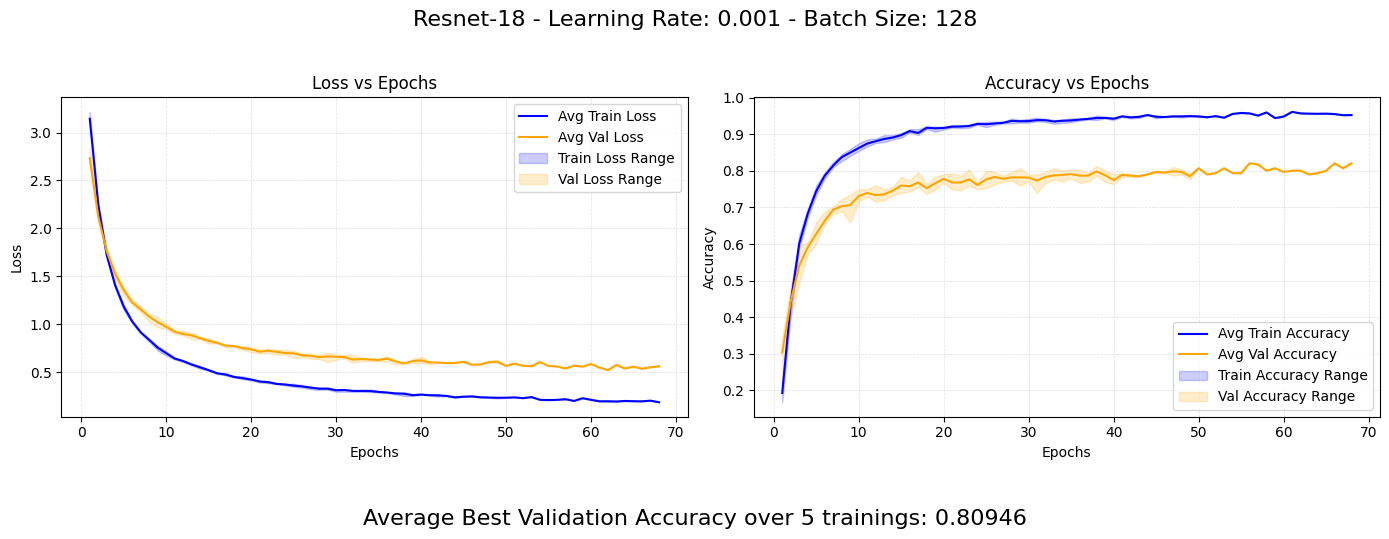

In [15]:
updated_config = config.copy()
learning_rate_to_test = [3e-4, 5e-4, 7e-4, 1e-3]
batch_size_to_test = [32, 64, 128]

results_resnet = {(lr, bs): {
                             "train_losses": [],
                             "val_losses": [],
                             "train_accuracies": [], 
                             "val_accuracies": [], 
                             "best_epoch": []
                             } for lr in learning_rate_to_test for bs in batch_size_to_test}

for learning_rate in learning_rate_to_test:
    for batch_size in batch_size_to_test:
        
        updated_config["batch_size"] = batch_size
        updated_config["learning_rate"] = learning_rate
        
        for training in range(config["num_trainings"]):
            resnet18_v2 = get_resnet18(num_classes=43, weights=ResNet18_Weights.IMAGENET1K_V1)
            train_losses, val_losses, train_acc, val_acc, best_epoch = train_and_validate(resnet18_v2, config=updated_config, model_name="resnet18_v2", verbose=False)
            
            results_resnet[(learning_rate, batch_size)]["train_losses"].append(train_losses)
            results_resnet[(learning_rate, batch_size)]["val_losses"].append(val_losses)
            results_resnet[(learning_rate, batch_size)]["train_accuracies"].append(train_acc)
            results_resnet[(learning_rate, batch_size)]["val_accuracies"].append(val_acc)
            results_resnet[(learning_rate, batch_size)]["best_epoch"].append(best_epoch)
            
        with open(os.path.join("results", f"resnet18_v2_{learning_rate}_{batch_size}.json"), 'w') as json_file:
            json.dump(results_resnet[(learning_rate, batch_size)], json_file, indent=4)
        
        plot_training_multiple_results(results_resnet[(learning_rate, batch_size)], title=f"Resnet-18 - Learning Rate: {learning_rate} - Batch Size: {batch_size}")
        

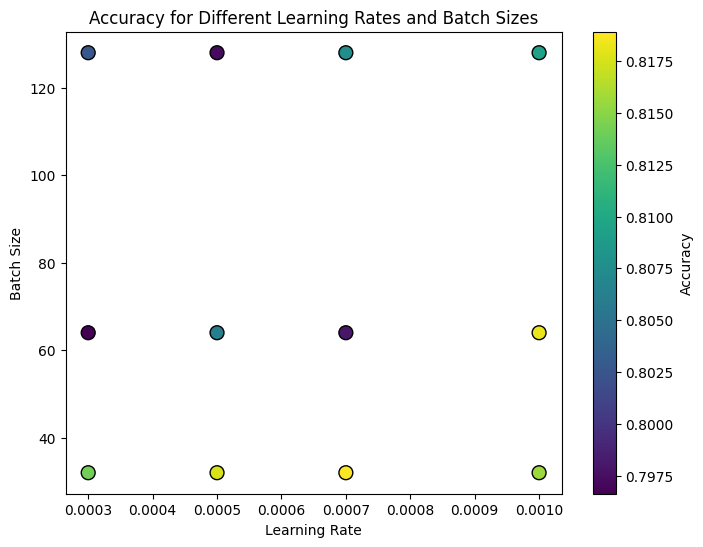

In [16]:
best_avg_val_accuracies = {}

for learning_rate in learning_rate_to_test:
    for batch_size in batch_size_to_test:
        val_accuracies = results_resnet[(learning_rate, batch_size)]["val_accuracies"]
        best_epochs = results_resnet[(learning_rate, batch_size)]["best_epoch"]
        avg_best_result = np.mean([val_accuracies[i][best_epochs[i]] for i in range(len(best_epochs))])
        best_avg_val_accuracies[(learning_rate, batch_size)] = avg_best_result

learning_rates = np.array([lr for lr, _ in best_avg_val_accuracies.keys()])
batch_sizes = np.array([bs for _, bs in best_avg_val_accuracies.keys()])
accuracies = np.array([acc for acc in best_avg_val_accuracies.values()])

plt.figure(figsize=(8,6))
scatter = plt.scatter(learning_rates, batch_sizes, c=accuracies, cmap='viridis', s=100, edgecolor='k')
plt.colorbar(scatter, label='Accuracy')

plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('Accuracy for Different Learning Rates and Batch Sizes')

plt.show()


## Res-Net with tweaked Parameters (2)

We also conducted a second test to make ResNet more task-specific by fine-tuning its last residual block, unfreezing `model.layer4`. For efficiency reasons, we chose to train only this layer, as it captures the highest-level features while preserving lower-level representations learned by earlier layers.

We performed a second grid search with smaller learning rates than in the previous setup to ensure a more controlled fine-tuning process, reducing the risk of destabilizing pretrained representations. We tested the same batch sizes as before.

Using this configuration, we improved the model’s performance from 0.8189 to 0.9074, measured under the same evaluation metric.

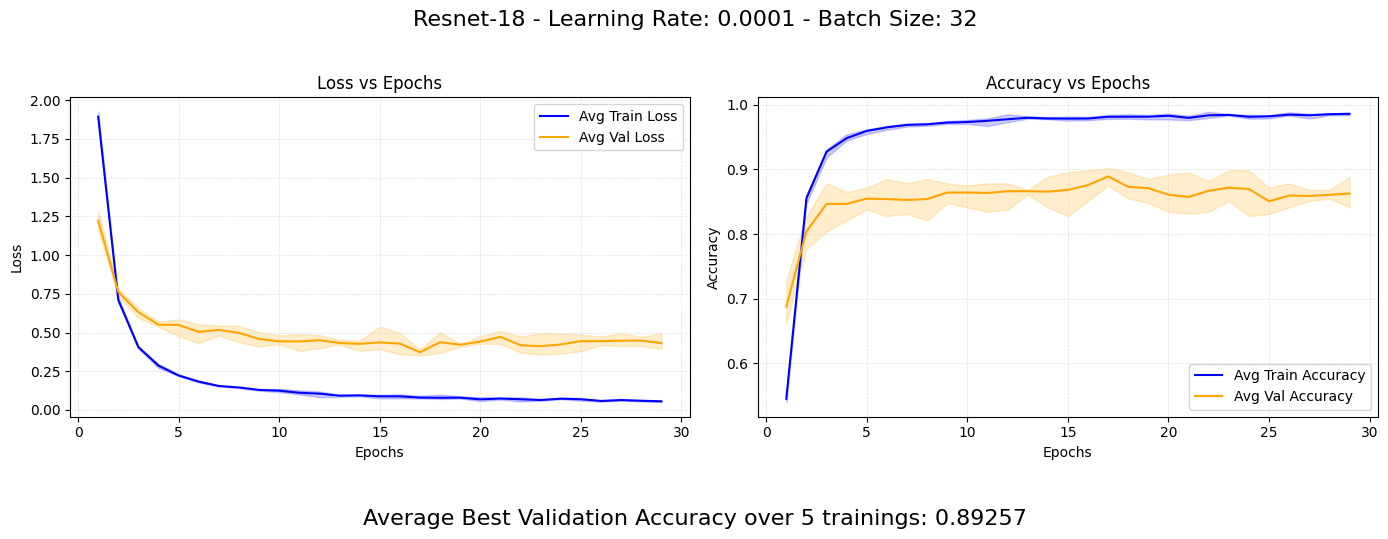

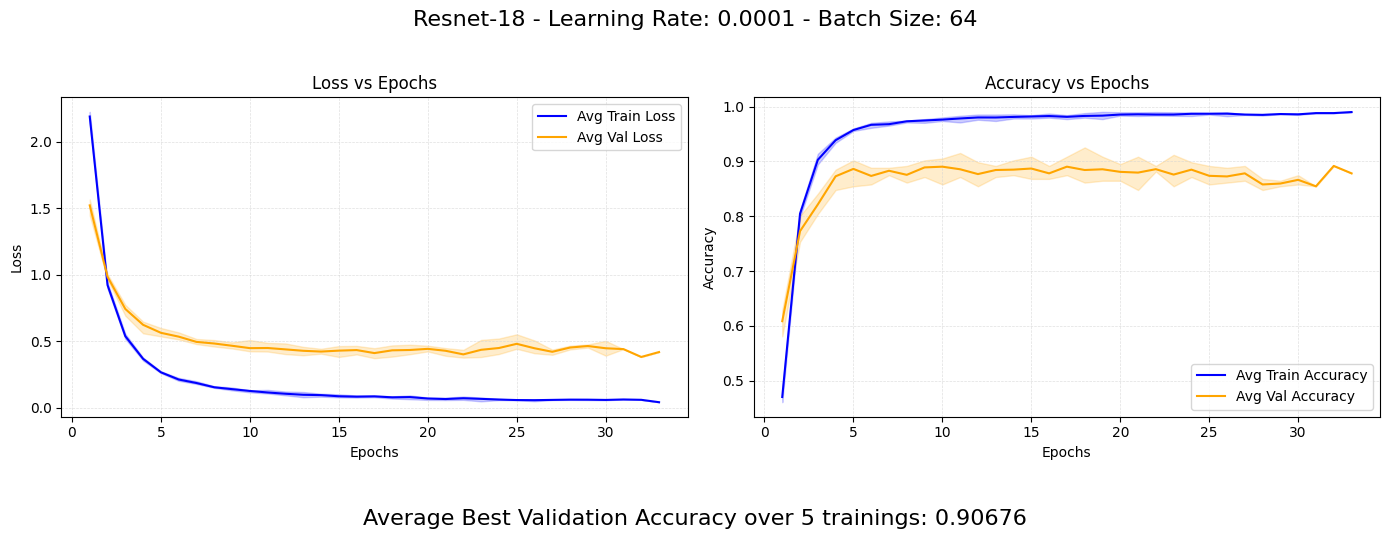

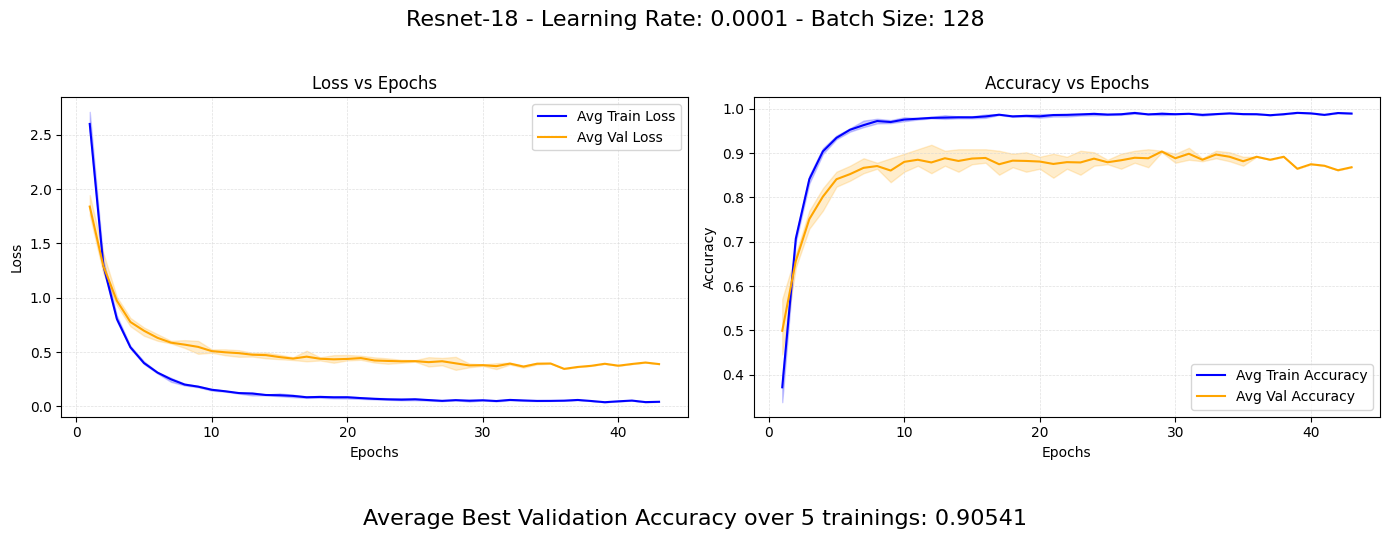

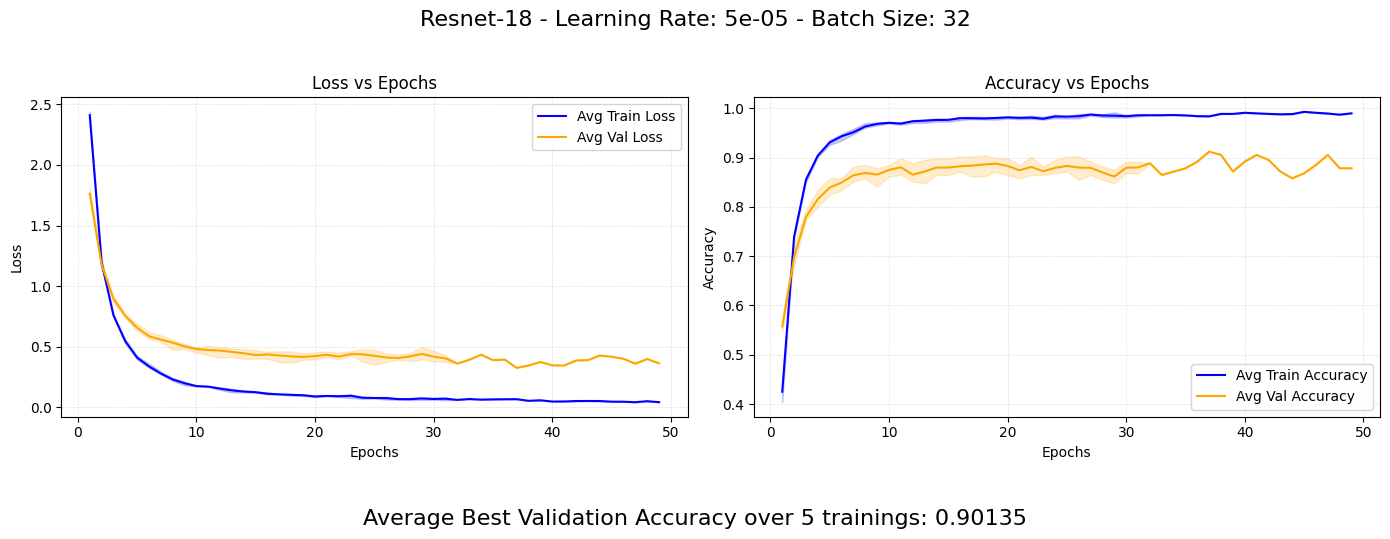

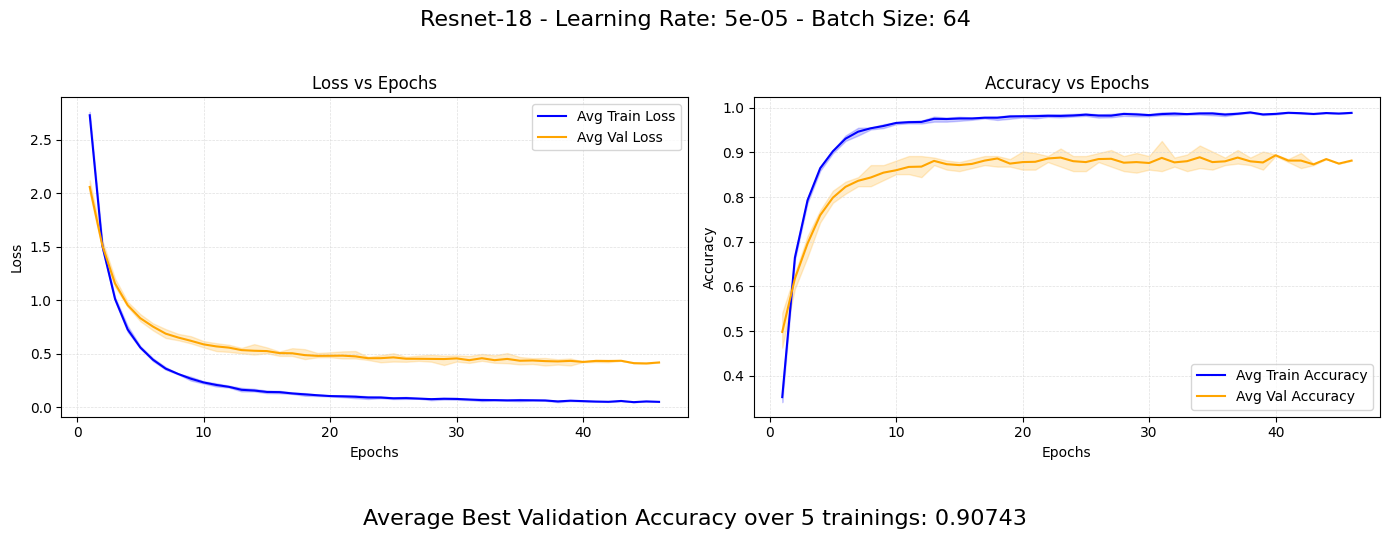

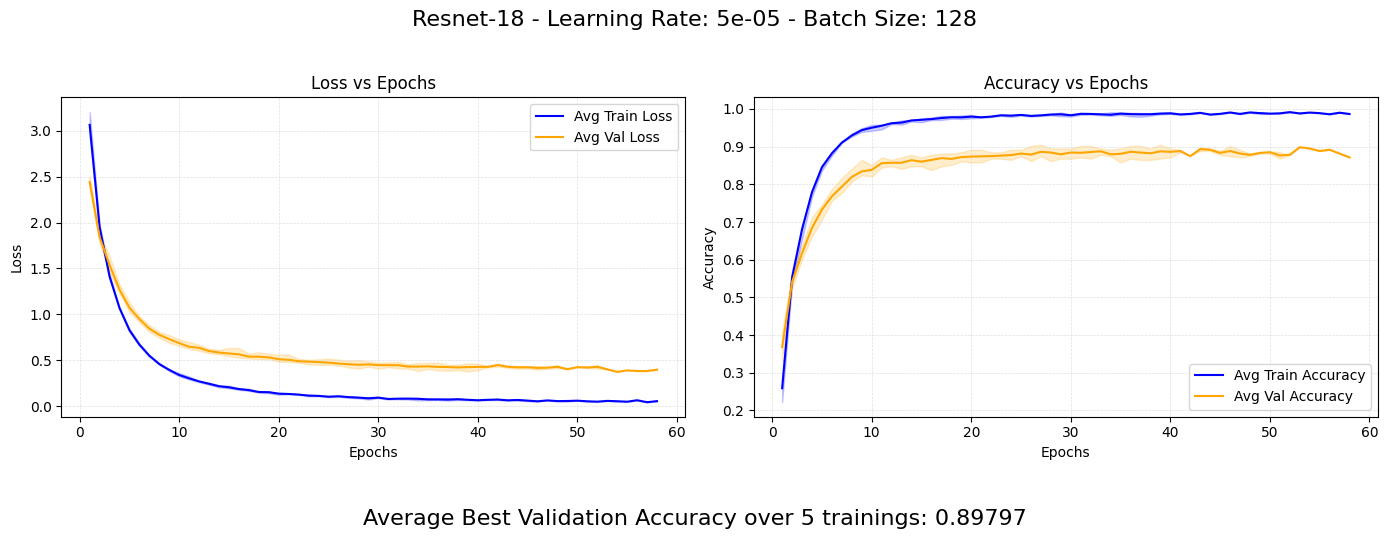

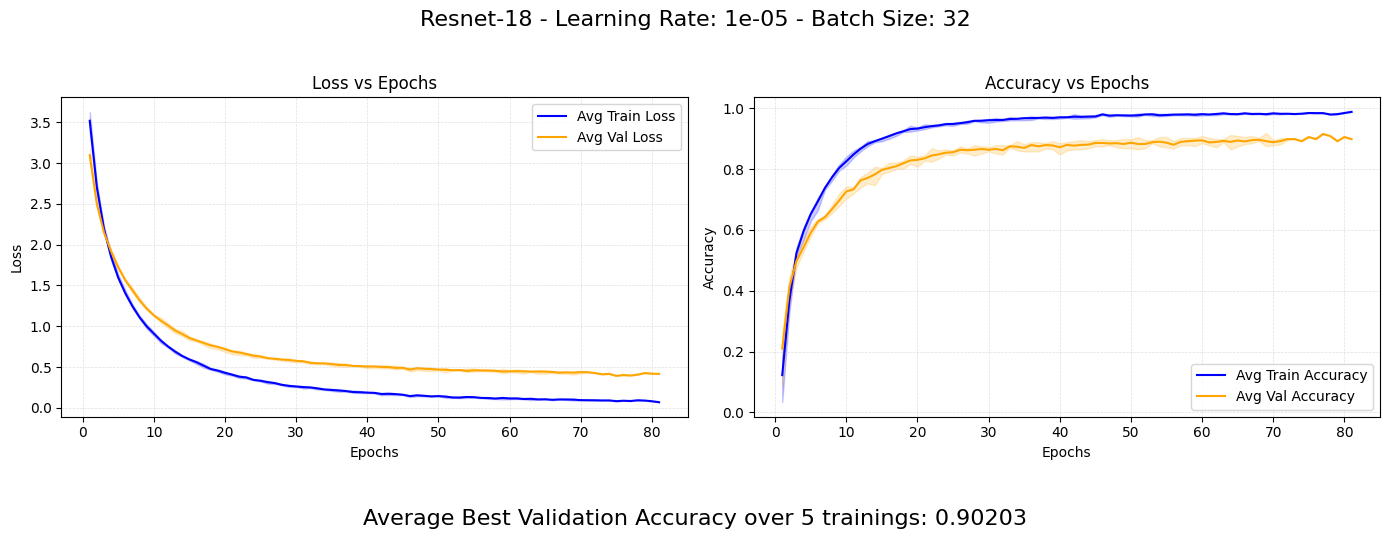

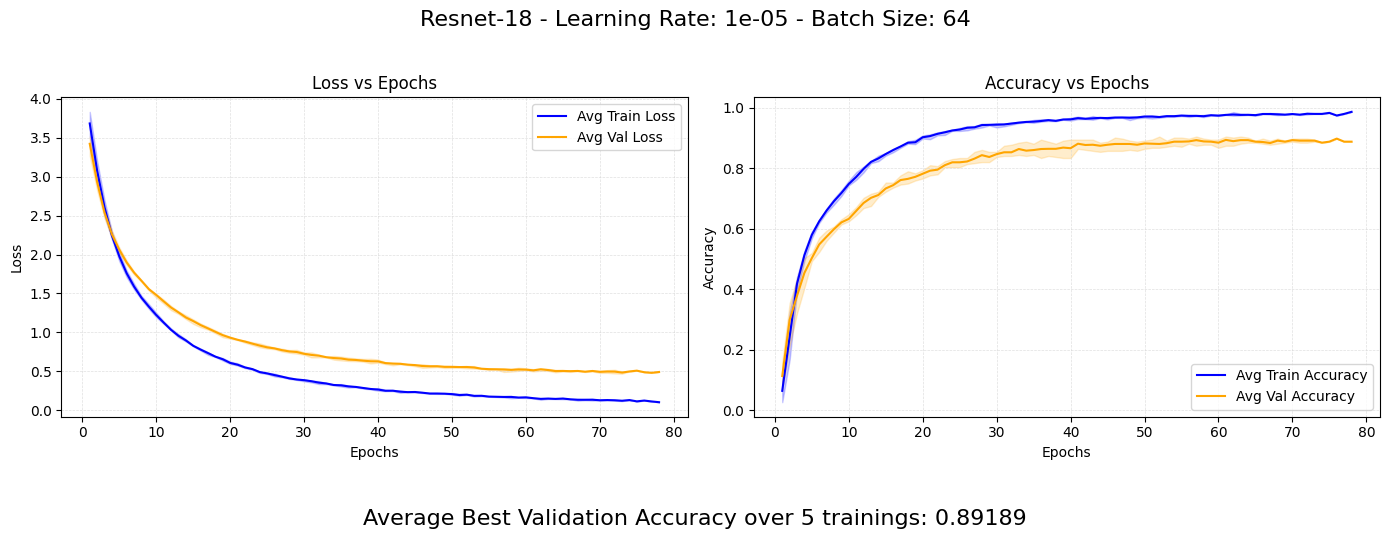

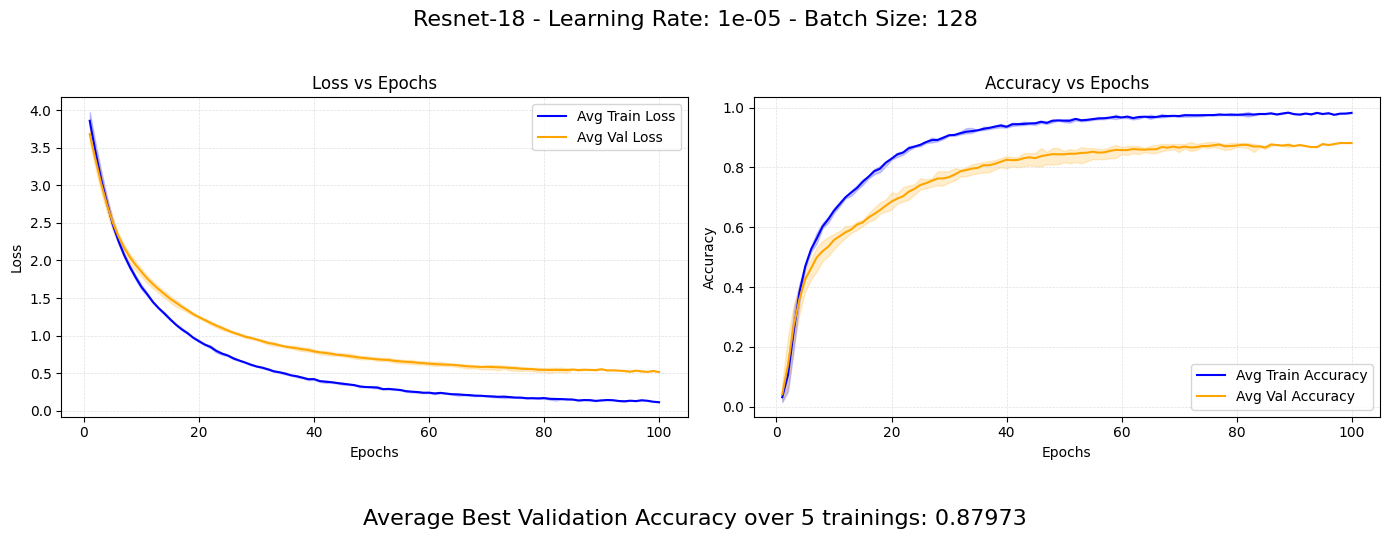

In [10]:
updated_config = config.copy()
learning_rate_to_test = [1e-4, 5e-5, 1e-5]
batch_size_to_test = [32, 64, 128]

results_resnet = {(lr, bs): {
                             "train_losses": [],
                             "val_losses": [],
                             "train_accuracies": [], 
                             "val_accuracies": [], 
                             "best_epoch": []
                             } for lr in learning_rate_to_test for bs in batch_size_to_test}

for learning_rate in learning_rate_to_test:
    for batch_size in batch_size_to_test:
        
        updated_config["batch_size"] = batch_size
        updated_config["learning_rate"] = learning_rate
        
        for training in range(config["num_trainings"]):
            resnet18_v2 = get_resnet18(num_classes=43, weights=ResNet18_Weights.IMAGENET1K_V1, unfreeze_last_layer=True)
            train_losses, val_losses, train_acc, val_acc, best_epoch = train_and_validate(resnet18_v2, config=updated_config, model_name="resnet18_v2", verbose=False)
            
            results_resnet[(learning_rate, batch_size)]["train_losses"].append(train_losses)
            results_resnet[(learning_rate, batch_size)]["val_losses"].append(val_losses)
            results_resnet[(learning_rate, batch_size)]["train_accuracies"].append(train_acc)
            results_resnet[(learning_rate, batch_size)]["val_accuracies"].append(val_acc)
            results_resnet[(learning_rate, batch_size)]["best_epoch"].append(best_epoch)
            
        with open(os.path.join("results", f"resnet18_v2_{learning_rate}_{batch_size}.json"), 'w') as json_file:
            json.dump(results_resnet[(learning_rate, batch_size)], json_file, indent=4)
        
        plot_training_multiple_results(results_resnet[(learning_rate, batch_size)], title=f"Resnet-18 - Learning Rate: {learning_rate} - Batch Size: {batch_size}")
        

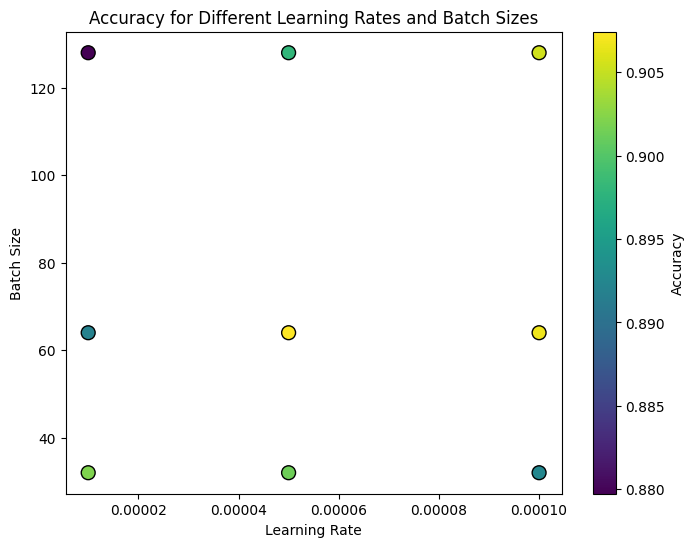

In [11]:
best_avg_val_accuracies = {}

for learning_rate in learning_rate_to_test:
    for batch_size in batch_size_to_test:
        val_accuracies = results_resnet[(learning_rate, batch_size)]["val_accuracies"]
        best_epochs = results_resnet[(learning_rate, batch_size)]["best_epoch"]
        avg_best_result = np.mean([val_accuracies[i][best_epochs[i]] for i in range(len(best_epochs))])
        best_avg_val_accuracies[(learning_rate, batch_size)] = avg_best_result

learning_rates = np.array([lr for lr, _ in best_avg_val_accuracies.keys()])
batch_sizes = np.array([bs for _, bs in best_avg_val_accuracies.keys()])
accuracies = np.array([acc for acc in best_avg_val_accuracies.values()])

plt.figure(figsize=(8,6))
scatter = plt.scatter(learning_rates, batch_sizes, c=accuracies, cmap='viridis', s=100, edgecolor='k')
plt.colorbar(scatter, label='Accuracy')

plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('Accuracy for Different Learning Rates and Batch Sizes')

plt.show()
